# Preliminaries

## Dataset

In this set of exercises we will use the same dataset as from [week 3](week_3.ipynb). 


As before, we provide the data already curated in the following two files:

`RNA_expression_curated.csv`: [148 cell lines , 238 genes]

`drug_response_curated.csv`: [148 cell lines , YM155 drug]

The curated data can be read as `pandas` `DataFrame` in the following way:

In [27]:
import pandas as pd

gene_expression = pd.read_csv("./data/RNA_expression_curated.csv", sep=',', header=0, index_col=0)
drug_response = pd.read_csv("./data/drug_response_curated.csv", sep=',', header=0, index_col=0)

The goal of the exercises is to train support vector machine (SVM) and random forests classifiers on this dataset and explore and learn about their hyperparameters. 

## Tools

The `scikit-learn` library provides the required tools for support vector machines, as well as for random forest algorithms.

In [2]:
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import classification_report

Before proceeding, look up the documentation of the imported functions and read about their basic functionality. Below, we list some important parameters of SVMs and random forests that can be tuned during training.

#### Support Vector Machines (SVM)

`C`: error term.

`kernel`: similarity function ('linear', 'poly', 'sigmoid' or 'rbf')

`gamma`: kernel coef. for 'rbf', 'poly' and 'sigmoid' kernels. It can be thought of as the ‘spread’ of the kernel and therefore the decision region.

`degree`: degree for the 'poly' kernel.

`coef0`: independt term in the 'poly' and 'sigmoid' kernels


#### Random Forests

`n_estimators`: number of trees in our random forest.

`max_depth`: maximum number of levels in each decision tree

`max_features`: maximum number of features to consider per split in an individual tree.

`min_sample_leaf`: minimum number of data points per leaf node

`min_samples_split`: minimum number of data points placed in a node before the node is split

`oob_score`: the out-of-bag (OOB) error is the average error for each observation calculated using predictions from the trees that do not contain that observation in their respective bootstrap sample. Set this parameter to true.

`bootstrap`: method for sampling data points (with or without replacement). Set this parameter to true.

`criterion`: function used to measure the quality of the split (e.g. 'entropy' or 'gini')

# Exercises

## Support vector machines

The  `make_blobs` and `make_circles` functions can be used to generate linearly and not linearly separable toy datasets. 

In [3]:
# data generation: linearly separable
X, Y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=1234)
X = pd.DataFrame(X, columns=['x1', 'x2'])

# splitting data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=333)

The following code illustrates how to train a linear SVM classifier and plot the data points, the separating hyperplane, the support vectors and the margins that pass through them (considering the training data)

c:\Users\mathi\anaconda3\envs\8dm50_1\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
c:\Users\mathi\anaconda3\envs\8dm50_1\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


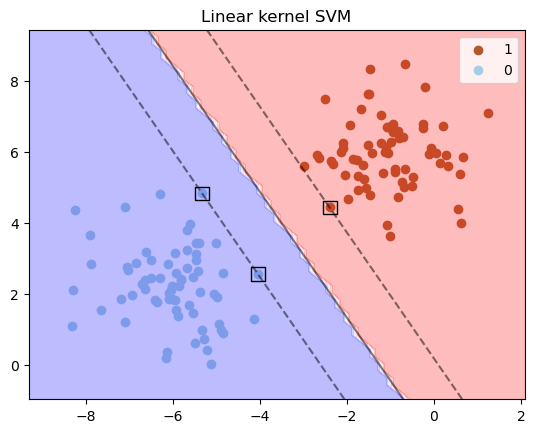

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# build the model
model = svm.SVC(kernel='linear', random_state=33)
model.fit(X_train, Y_train)

# create plot
fig, ax = plt.subplots()

# get colors from qualitative colormap 'Paired'
cmap = plt.cm.get_cmap('Paired')

# plot data points
ax.scatter(X_train.iloc[Y_train == 1, 0], X_train.iloc[Y_train == 1, 1],
           c=[cmap(11)], label='1')
ax.scatter(X_train.iloc[Y_train == 0, 0], X_train.iloc[Y_train == 0, 1],
           c=[cmap(0)], label='0')
ax.legend(loc='best')

# plot the decision function
# create grid to evaluate model
x1_min, x1_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
x2_min, x2_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1

XX, YY = np.meshgrid(np.arange(x1_min, x1_max, .2),
                     np.arange(x2_min, x2_max, .2))

xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Establish the class for each point in the contour
Z = model.predict(xy).reshape(XX.shape)

# Visualization of the contour
ax.contourf(XX, YY, Z, cmap='bwr', alpha=0.3)

# plot support vectors, whose are responsible for building the margins
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', marker='s')

ax.axis([x1_min, x1_max, x2_min, x2_max])
plt.axis('tight')
plt.title('Linear kernel SVM')
plt.show()

Train a radial basis function (RBF) SVM classifier with `gamma=0.5` and plot the results in the same way.

In [5]:
# data generation: not linearly separable
X, Y = make_circles(n_samples=200, noise=0.05, random_state=1234)
X = pd.DataFrame(X, columns=['x1', 'x2'])

# splitting data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=333)

C:\Users\20182717\AppData\Local\Temp\ipykernel_10640\3117567123.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired')
c:\Users\20182717\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\20182717\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


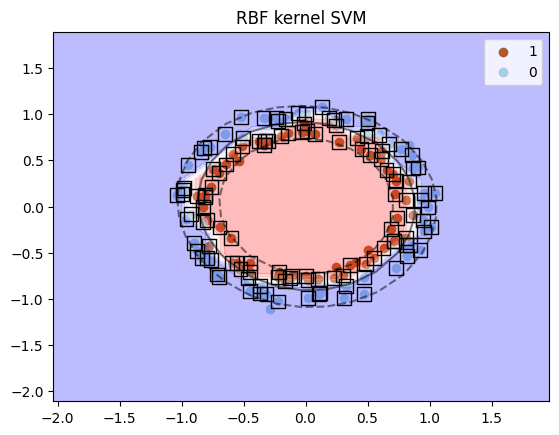

In [14]:
# build the model
model = svm.SVC(kernel='rbf', gamma=0.5, random_state=33)
model.fit(X_train, Y_train)

# create plot
fig, ax = plt.subplots()

# get colors from qualitative colormap 'Paired'
cmap = plt.cm.get_cmap('Paired')

# plot data points
ax.scatter(X_train.iloc[Y_train == 1, 0], X_train.iloc[Y_train == 1, 1],
           c=[cmap(11)], label='1')
ax.scatter(X_train.iloc[Y_train == 0, 0], X_train.iloc[Y_train == 0, 1],
           c=[cmap(0)], label='0')
ax.legend(loc='best')

# plot the decision function
# create grid to evaluate model
x1_min, x1_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
x2_min, x2_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1

XX, YY = np.meshgrid(np.arange(x1_min, x1_max, .2),
                     np.arange(x2_min, x2_max, .2))

xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Establish the class for each point in the contour
Z = model.predict(xy).reshape(XX.shape)

# Visualization of the contour
ax.contourf(XX, YY, Z, cmap='bwr', alpha=0.3)

# plot support vectors, whose are responsible for building the margins
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', marker='s')

ax.axis([x1_min, x1_max, x2_min, x2_max])
plt.axis('tight')
plt.title('RBF kernel SVM')
plt.show()

<p><font color='#770a0a'>When should a RBF kernel be used over a linear kernel? Motivate your answer.</font></p>


Answer: In general, a linear kernel should be used if the data is linearly seperable. A radial basis function kernel is better at classification of complex or nonlinearly patterned or clustered data. This makes it more versatile, since it also has no problem in correctly classifiyng the 'blob' toy data. But, this comes at the cost of the use of more support vectors, and thus a somewhat more complex model. Therefore it is not the best choice in every case.


<p><font color='#770a0a'>Do we need to normalize the data before using a kernel function? Motivate your answer.
</font></p>

Answer: That would depend on the data as well as the distance function used. For example, when looking at data with big differences in ranges in dimensions, say a first dimension that ranges from 0-10 and a second dimension that ranges from 0-1, a change of 1 in the first (one-tenth of the range) would contribute as much as a change of 1 in the second (half of the range). So if euclidean distance is used, small distances in the first dimension would be exaggerated. In this case normalisation could ameliorate this bias. In other cases normalisation would not have an added value, such as the toy blob dataset above, seeing as in that case the data is already quite differentiated in both dimensions. Another case could be that you want certain aspects of you data to be accounting for more influence on the training, if they were important features for example. Then normalisation could destroy their bigger contribution. 

In conclusion, normalisation is in many cases a good idea for svm's. However, as always you should know your data and make informed decisions that lead to the best result in your particular case.

## Predicting drug response on cell lines from gene expression data with SVMs

Explore the hyper-parameter space of an SVM classifier with cross-validation for the Genomics of Drug Sensitivity in Cancer (GDSC) dataset. The`GridSearchCV` function can be used to specify a grid of parameter values with the `param_grid` parameter.

Calculate the precision of your predictions, and compare your calculations with the results of `classification_report`, which displays many classification metrics.


## Random forests

Follow the same steps as for SVM. Compare the two algorithms and report which one has better performance.

The random forests classifiers allows to perform feature selection. Evaluate the importance of features extracting the top 50 informative features. A bar plot (`plt.bar()`) can be a useful tool to visualize this. 


## Biomedical applications

Driven by technological advances, there has recently been a dramatic increase in availability of biomedical data. Machine learning approaches are well suited to take advantage of this data and have been widely applied to many areas of biology. 

Example of these applications are genome annotation, biomarker identification, systems biology, genome data analysis, protein  function  prediction, protein  structure prediction, protein localization prediction, identification of protein interactions and drug discovery.

SVM and RF methods are among the most popular machine learning methods applied in bioinformatics or computational biology.

Perform a literature search and find a biomedical study in which SVM or RF is applied to obtain certain insights. <p><font color='#770a0a'>Explain the motivation behind using that specific algorithm in the study.
</font></p>

In [ ]:
#Runtime: ~2 min
# Predicting  drug response SVM
import warnings
from sklearn.exceptions import DataConversionWarning

#Copy the data
svm_drug_response = drug_response.copy()
svm_gene_expression = gene_expression.copy()

# Splitting and preparing the data
mean = svm_drug_response.mean()
std = svm_drug_response.std()
svm_drug_response['z_score'] = (svm_drug_response-mean)/std

# Values are sensitive (value =1) or insensitive 0
svm_drug_response['classification'] = svm_drug_response['z_score'].apply(lambda x: 1 if x < 0 else 0)
X_train, X_test, y_train, y_test = train_test_split(svm_gene_expression, svm_drug_response['classification'])

# Initializing the parameters and model
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'kernel': ['linear', 'poly', 'sigmoid', 'rbf'],
              'gamma': [1e-3, 1e-2, 1e-1, 1, 10, 100],
              'degree': [2, 3, 4, 5],
              'coef0': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0]}
n_folds = 10
svm_est = svm.SVC()

# Setting up the gridsearch
gridsearch_svm = GridSearchCV(estimator=svm_est, param_grid=parameters, cv=n_folds)

with warnings.catch_warnings():  # disable overly verbose warnings
    warnings.simplefilter("ignore", category=DataConversionWarning)
    # Fitting the data and predicting
    gridsearch_svm.fit(X_train, y_train)
    y_pred = gridsearch_svm.predict(X_test)

# Calculate precision
true_pos = sum((y_pred==1) & (y_test==1))
false_pos = sum((y_pred==1) & (y_test==0))
precision = true_pos / (true_pos + false_pos)

# Print the necessary values for analysis
print(precision)
print(classification_report(y_pred=y_pred, y_true=y_test))

Paper: Jiang, D., Lei, T., Wang, Z. et al. ADMET evaluation in drug discovery. 20. Prediction of breast cancer resistance protein inhibition through machine learning. _J Cheminform_ **12**, 16 (2020). https://doi.org/10.1186/s13321-020-00421-y

_Paper is chosen because it is recent (2020) and has a very interesting comparison between various ML methods where an SVM came out on top, with a biomedically very relevant topic._ 

In the research by Jiang et al., seven different machine learning algorithms are built in order to determine if a query compound is an inhibitor for breast cancer resistance protein (BCRP) based on simple chemical features, the use of which would improve prognosis. As the methods should differentiate between BCRP inhibitors and non-inhibitors, a support vector machine (SVM) was a logical choice. The main reasoning in the paper is because SVMs excell in complex, but small- to medium-sized datasets. Moreover, SVMs capability to find a separating hyperplane with maximum margin in the feature space makes it suitable for classifying inhibitors and non-inhibitors effectively. Therefore, it has outperformed other traditional ML methods (Naive Bayes, k-Nearest neighbors and Regularized logistic regression) as well as more complex methods, including Ensemble and deep learning methods when evaluated with Matthews correlation coefficient (MCC). Lastly, when further reviewing residual distributions for all well-scoring algorithms, SVM came out on top as final recommendation.

Nonetheless, the SVM model still misclassified some compounds. This can possibly be attributed to the fact that these compounds generally have fragments which are not abundant in the dataset. These infrequent fragments could therefore lower the accuracy of a very binary model like an SVM.